In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import openbabel
from openbabel import pybel
import rdkit
import os
import sys

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

# Get the current working directory
current_dir = os.getcwd()

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Now you can import the module
from generator import fingerprint
from generator import generation
from generator import filters
from generator import scoring
from generator import visualization

In [2]:
liga_smiles = "O=C(Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1)c1ccccc1" #tyk2-43
ligb_smiles = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-44
num_tries = 2
num_random_smiles = 2
num_random_samples = 2
collect_bidirectional = True
exponent_path = 1
n_rounds = 1
fp_type = "ECFP4"



In [3]:
def visualise(liga_smiles, ligb_smiles, selected_intermediate_smiles):
    """
    Visualise and save an image of three aligned ligands with the Maximum Common Substructure (MCS) highlighted.
    
    Args:
        liga_smiles, ligb_smiles, selected_intermediate_smiles (str): The SMILES strings for the ligands to visualize.
        mins, secs (int): The minutes and seconds elapsed.
        filepath (str): The path to the location where the image is to be saved.
        filename (str): The name of the file.
    """
    # get intermediate
    liga = Chem.MolFromSmiles(liga_smiles)
    ligb = Chem.MolFromSmiles(ligb_smiles)
    intermediate = Chem.MolFromSmiles(selected_intermediate_smiles)

    # find MCS of the 3 molecules
    mcs_mol = filters.find_mcs_3_mols(liga_smiles, ligb_smiles, selected_intermediate_smiles)

    # Align ligands 
    molecules = visualization.alignLigands(liga, intermediate, ligb)

    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Generate the images with the MCS highlighted
    img0 = visualization.draw_molecule_with_mcs(liga, mcs_mol)
    img1 = visualization.draw_molecule_with_mcs(intermediate, mcs_mol)
    img2 = visualization.draw_molecule_with_mcs(ligb, mcs_mol)

    # Plot the images
    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)


    # Turn off axes and set titles.
    titles = [r"$\lambda = 0$", r"Intermediate", r"$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # set spacing between plots
    plt.subplots_adjust(wspace=0.08)



    plt.show()



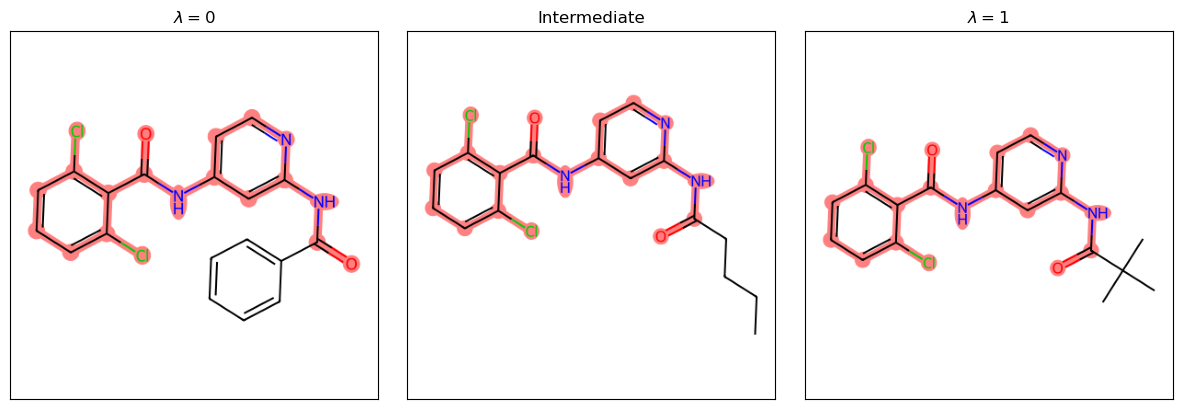

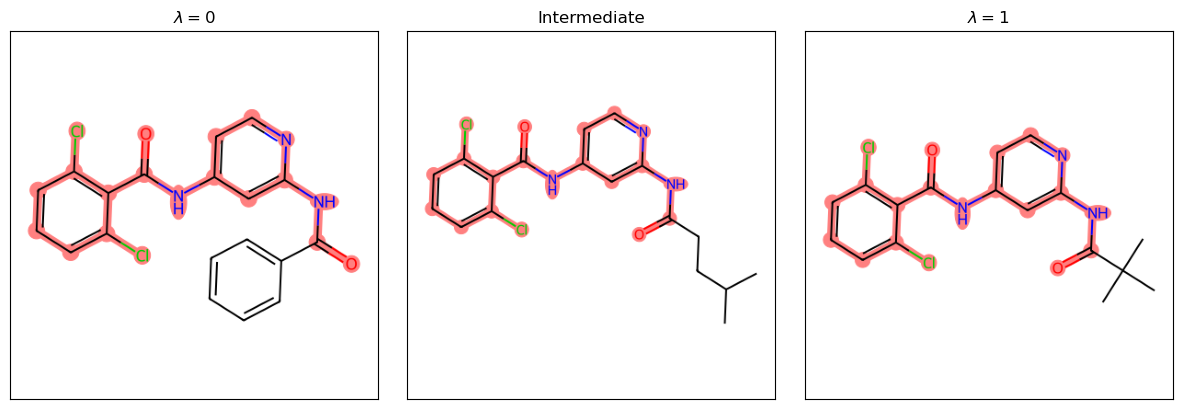

In [4]:
visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

The code above is able to succesfully glue logical stuff back at the right location. however, the tag is probably wrong, since the glue position is not correct. 

In [5]:
def find_mcs_and_expand_with_connector(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS), expand it to include the connecting atom
    to the R-group, and return the expanded MCS and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (Expanded MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Expand MCS to include the connecting atom
    connector_a = find_connector_atom(mol_a, match_a, atoms_a)
    connector_b = find_connector_atom(mol_b, match_b, atoms_b)
    
    # Add the connector atom to the match (expanding the MCS)
    expanded_match_a = list(match_a) + [connector_a]
    expanded_match_b = list(match_b) + [connector_b]
    
    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Map original atom indices to submolecule atom indices
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, expanded_match_a, expanded_match_b


def find_connector_atom(mol, match, rgroup_atoms):
    """
    Find the connector atom, which is part of the MCS but directly connected to the R-group.
    
    Args:
    mol (rdkit Mol): The original molecule.
    match (list): List of atoms that are part of the MCS.
    rgroup_atoms (list): List of atoms that are part of the R-group.
    
    Returns:
    int: The index of the connector atom.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()
            if neighbor_idx in match:
                return neighbor_idx
    return None  # Should always find a connector atom


In [6]:
from rdkit.Chem import rdFMCS

def find_mcs_with_mapping(mol_a, mol_b):
    """
    Find the MCS between two molecules and return the MCS along with atom mappings
    from the original molecules to the MCS.

    Args:
    mol_a (rdkit Mol): The first molecule.
    mol_b (rdkit Mol): The second molecule.

    Returns:
    tuple: MCS molecule, atom mapping from mol_a to MCS, atom mapping from mol_b to MCS.
    """
    mcs_result = rdFMCS.FindMCS([mol_a, mol_b], 
                                atomCompare=rdFMCS.AtomCompare.CompareElements,
                                bondCompare=rdFMCS.BondCompare.CompareAny,
                                matchValences=False,
                                ringMatchesRingOnly=True,
                                completeRingsOnly=True,
                                matchChiralTag=False,
                                timeout=2)
    
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    # Get the mapping from the original molecules to the MCS
    mapping_a = mol_a.GetSubstructMatch(mcs_mol)
    mapping_b = mol_b.GetSubstructMatch(mcs_mol)
    
    return mcs_mol, mapping_a, mapping_b

def find_connector_atom_with_mapping(mol, rgroup_atoms, mapping):
    """
    Identify the correct connector atom in the MCS by mapping the original atom that was
    connected to the R-group in the full molecule.

    Args:
    mol (rdkit Mol): The original molecule.
    rgroup_atoms (list): List of atoms that are part of the R-group in the full molecule.
    mapping (list): Mapping of atom indices from the full molecule to the MCS.

    Returns:
    int: The index of the connector atom in the MCS.
    """
    for rgroup_atom in rgroup_atoms:
        atom = mol.GetAtomWithIdx(rgroup_atom)
        for neighbor in atom.GetNeighbors():
            neighbor_idx = neighbor.GetIdx()

            # If the neighbor is part of the MCS (i.e., mapped), return the corresponding MCS atom
            if neighbor_idx in mapping:
                mcs_idx = mapping.index(neighbor_idx)  # Find the corresponding MCS atom
                print(f"Found connector atom {mcs_idx} in the MCS (original atom {neighbor_idx})")
                return mcs_idx

    raise ValueError("No valid connector atom found.")


In [7]:
def visualize_mcs_with_connector(mcs, connector_atom_idx):
    """
    Visualize the MCS with the connector atom highlighted.

    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    connector_atom_idx (int): The index of the connector atom to highlight.
    """
    # Ensure a valid connector atom index is provided
    if connector_atom_idx is None:
        raise ValueError("No valid connector atom was found.")

    # Set up atom highlight color
    highlight_atoms = [connector_atom_idx]
    highlight_colors = {connector_atom_idx: (1, 0, 0)}  # Red color for connector atom
    
    # Generate 2D coordinates for the MCS
    Chem.rdDepictor.Compute2DCoords(mcs)
    
    # Draw the molecule with the highlighted connector atom
    img = Draw.MolToImage(mcs, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors, size=(300, 300))
    
    # Display the image
    img.show()

# Example usage after finding the MCS and connector atom
mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_expand_with_connector(liga_smiles, ligb_smiles)
connector_atom_idx = find_connector_atom(Chem.MolFromSmiles(liga_smiles), match_a, list(map_a.keys()))

# Check if a valid connector atom was found
# if connector_atom_idx is not None:
#     # Visualize the MCS with the connector atom highlighted
#     #visualize_mcs_with_connector(mcs, connector_atom_idx)            #### if you use this you will get the wrong connector atom, however part of this function is needed
# else:
#     print("No valid connector atom was found.")


In [8]:
mol_a = Chem.MolFromSmiles(liga_smiles)
mol_b = Chem.MolFromSmiles(ligb_smiles)

mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_expand_with_connector(liga_smiles, ligb_smiles)

# Find the MCS and atom mappings
mcs, mapping_a, mapping_b = find_mcs_with_mapping(mol_a, mol_b)

# Find the connector atom in the MCS
connector_atom_idx = find_connector_atom_with_mapping(mol_a, list(map_a.keys()), mapping_a)

# Visualize the MCS with the connector atom highlighted
visualize_mcs_with_connector(mcs, connector_atom_idx)


##### this one does the mapping correctly

Found connector atom 0 in the MCS (original atom 1)


In [13]:
def glue_rgroup_to_mcs(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.

    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.

    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Print atom details for debugging
    print(f"Attaching R-group at atom {rgroup_tag} (element {rgroup.GetAtomWithIdx(rgroup_tag).GetSymbol()}) to MCS at atom {mcs_tag} (element {mcs.GetAtomWithIdx(mcs_tag).GetSymbol()})")

    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)

    # Adjust the R-group atom index to account for the MCS atoms
    adjusted_rgroup_tag = rgroup_tag + mcs.GetNumAtoms()

    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)

    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, adjusted_rgroup_tag, order=Chem.BondType.SINGLE)

    # Get the final molecule
    final_molecule = editable_combined.GetMol()

    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)

    return final_molecule



def attach_rgroups_to_mcs(mcs, rgroup_1, rgroup_2, connector_atom_idx_a, connector_atom_idx_b, rgroup_atom_a, rgroup_atom_b):
    """
    Attach R-group 1 and R-group 2 to the MCS at the respective connector atoms.

    Args:
    mcs (rdkit Mol): The MCS molecule.
    rgroup_1 (rdkit Mol): The first R-group molecule.
    rgroup_2 (rdkit Mol): The second R-group molecule.
    connector_atom_idx_a (int): The index of the connector atom in MCS for R-group 1.
    connector_atom_idx_b (int): The index of the connector atom in MCS for R-group 2.
    rgroup_atom_a (int): The index of the attachment point in R-group 1.
    rgroup_atom_b (int): The index of the attachment point in R-group 2.

    Returns:
    list: List of the final reconstructed molecules as SMILES strings.
    """
    # Attach R-group 1 to the MCS
    mol_with_rgroup_1 = glue_rgroup_to_mcs(mcs, rgroup_1, rgroup_atom_a, connector_atom_idx_a)
    
    # Attach R-group 2 to the MCS
    mol_with_rgroup_2 = glue_rgroup_to_mcs(mcs, rgroup_2, rgroup_atom_b, connector_atom_idx_b)

    # Convert to SMILES for easy comparison
    smiles_1 = Chem.MolToSmiles(mol_with_rgroup_1)
    smiles_2 = Chem.MolToSmiles(mol_with_rgroup_2)

    return [smiles_1, smiles_2]


In [24]:
def glue_rgroup_to_mcs(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.

    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.

    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Sanitize the R-group to ensure proper valence calculations
    try:
        Chem.SanitizeMol(rgroup, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
    except Exception as e:
        print(f"R-group sanitization failed: {e}")
        raise e

    # Disable kekulization for the MCS as well
    try:
        Chem.SanitizeMol(mcs, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
    except Exception as e:
        print(f"MCS sanitization failed: {e}")
        raise e

    # Debug: Print atom counts and atom indices
    print(f"MCS has {mcs.GetNumAtoms()} atoms")
    print(f"R-group has {rgroup.GetNumAtoms()} atoms")
    print(f"R-group atom to attach: {rgroup_tag}, MCS atom to attach: {mcs_tag}")

    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)

    # Print the number of atoms in the combined molecule
    print(f"\nCombined molecule has {combined.GetNumAtoms()} atoms")

    # Adjust the R-group atom index to account for the MCS atoms
    # Ensure the index is correct by checking if it's already an adjusted index
    if rgroup_tag >= rgroup.GetNumAtoms():
        adjusted_rgroup_tag = rgroup_tag  # The R-group atom index is already adjusted
    else:
        adjusted_rgroup_tag = rgroup_tag + mcs.GetNumAtoms()  # Adjust by adding MCS atoms

    print(f"Adjusted R-group atom index for attachment: {adjusted_rgroup_tag}")

    if adjusted_rgroup_tag >= combined.GetNumAtoms():
        print(f"Error: Adjusted R-group atom index {adjusted_rgroup_tag} is out of range")
        raise ValueError(f"Adjusted R-group atom index {adjusted_rgroup_tag} is out of range for combined molecule")

    if mcs_tag >= combined.GetNumAtoms():
        print(f"Error: MCS atom index {mcs_tag} is out of range")
        raise ValueError(f"MCS atom index {mcs_tag} is out of range for combined molecule")

    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)

    # Add a bond between the tagged atoms
    print(f"Adding bond between MCS atom {mcs_tag} and R-group atom {adjusted_rgroup_tag}")
    editable_combined.AddBond(mcs_tag, adjusted_rgroup_tag, order=Chem.BondType.SINGLE)

    # Get the final molecule
    final_molecule = editable_combined.GetMol()

    # Sanitize the molecule to ensure it's valid, with kekulization turned off
    try:
        Chem.SanitizeMol(final_molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
        print("Molecule successfully sanitized.")
    except Exception as e:
        print(f"Sanitization failed: {e}")
        raise e

    return final_molecule





In [25]:
# Example molecules (using SMILES)
mol_a = Chem.MolFromSmiles(liga_smiles)
mol_b = Chem.MolFromSmiles(ligb_smiles)

# Find the MCS and atom mappings
mcs, mapping_a, mapping_b = find_mcs_with_mapping(mol_a, mol_b)

# Find the connector atoms in the MCS
connector_atom_idx_a = find_connector_atom_with_mapping(mol_a, list(map_a.keys()), mapping_a)
connector_atom_idx_b = find_connector_atom_with_mapping(mol_b, list(map_b.keys()), mapping_b)

# Indices of the atoms in the R-groups to attach (replace these with the actual indices)
rgroup_atom_a = list(map_a.keys())[0]  # Example atom index for R-group 1
rgroup_atom_b = list(map_b.keys())[0]  # Example atom index for R-group 2

# Attach the R-groups to the MCS and get the final molecules
final_smiles = attach_rgroups_to_mcs(mcs, rgroup_1, rgroup_2, connector_atom_idx_a, connector_atom_idx_b, rgroup_atom_a, rgroup_atom_b)

# Print the final reconstructed molecules
print(f"Reconstructed Molecule 1: {final_smiles[0]}")
print(f"Reconstructed Molecule 2: {final_smiles[1]}")


Found connector atom 0 in the MCS (original atom 1)
Found connector atom 0 in the MCS (original atom 4)
MCS has 20 atoms
R-group has 8 atoms
R-group atom to attach: 20, MCS atom to attach: 0

Combined molecule has 28 atoms
Adjusted R-group atom index for attachment: 20
Adding bond between MCS atom 0 and R-group atom 20
Molecule successfully sanitized.
MCS has 20 atoms
R-group has 5 atoms
R-group atom to attach: 0, MCS atom to attach: 0

Combined molecule has 25 atoms
Adjusted R-group atom index for attachment: 20
Adding bond between MCS atom 0 and R-group atom 20
Molecule successfully sanitized.
Reconstructed Molecule 1: ccccccC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1.cn
Reconstructed Molecule 2: CC(C)(C)CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1


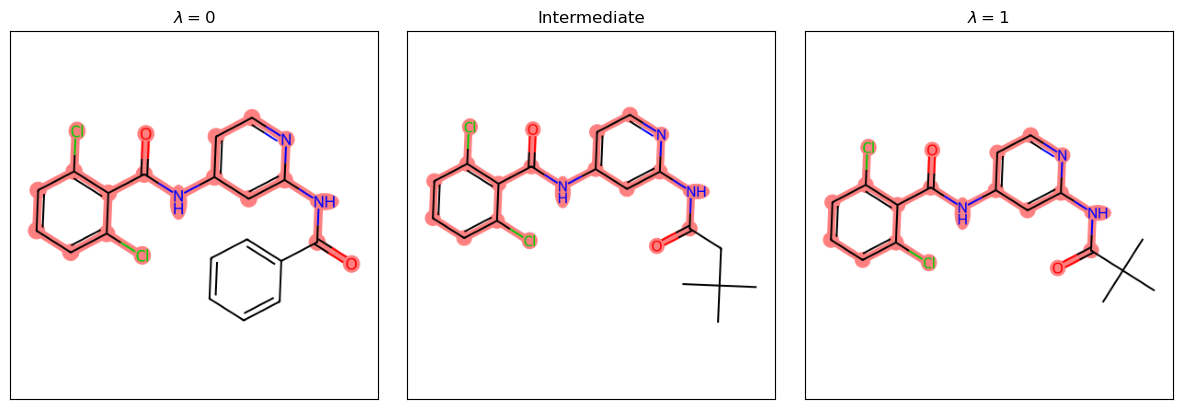

In [27]:
visualise(liga_smiles, ligb_smiles, 'CC(C)(C)CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
